This notebook explores the accuracy loss we obtain as a consequence of applying
decimation and heterodyning in the incorrect order at training time.

At inference, we take the measured gravitational-wave strain, heterodyne it with
respect to `chirp_mass_proxy` and then decimate to the `MultibandedFrequencyDomain`.
During training we need to apply the analogous transformations, i.e., (a1) heterodyne
with `chirp_mass_proxy` and (a2) decimate. However, for space reasons we store
decimated waveforms. This requires us to (b1) heterodyne with `chirp_mass`, (b2)
decimate and (b3) change heterodyning from `chirp_mass` to `chirp_mass_proxy`. Due to
the decimation step, `(b1,b2,b3)` is not identical to `(a1,a2)`. We here check that the
 mismatches that arise as a consequence of this are indeed small.

In [1]:
import numpy as np

np.random.seed(1)
import yaml
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

from dingo.gw.domains import build_domain, FrequencyDomain
from dingo.gw.prior import build_prior_with_defaults
from dingo.gw.waveform_generator import WaveformGenerator
from dingo.gw.dataset.generate_dataset import (
    WaveformDataset,
    generate_parameters_and_polarizations,
    train_svd_basis,
)
from dingo.gw.SVD import ApplySVD
from dingo.gw.gwutils import get_mismatch

from multibanded_frequency_domain import MultibandedFrequencyDomain
from multibanding_utils import (
    get_periods,
    number_of_zero_crossings,
    get_decimation_bands_adaptive,
    get_decimation_bands_from_chirp_mass,
    duration_LO,
)
from heterodyning import factor_fiducial_waveform, change_heterodyning
from bns_transforms import ApplyHeterodyning, ApplyDecimation

In [2]:
with open("waveform_dataset_settings.yaml", "r") as f:
    settings = yaml.safe_load(f)
num_processes = 10

In [3]:
ufd = build_domain(settings["domain"])
prior = build_prior_with_defaults(settings["intrinsic_prior"])
waveform_generator = WaveformGenerator(domain=ufd, **settings["waveform_generator"])
waveform_generator_het = WaveformGenerator(
    domain=ufd, transform=ApplyHeterodyning(ufd), **settings["waveform_generator"]
)
# generate polarizations
parameters_het, polarizations_het = generate_parameters_and_polarizations(
    waveform_generator_het, prior, 100, num_processes
)

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.
Generating dataset of size 100


In [4]:
bands = get_decimation_bands_adaptive(
    ufd,
    np.concatenate(list(polarizations_het.values())),
    min_num_bins_per_period=16,
    delta_f_max=3.0,
)
mfd = MultibandedFrequencyDomain(bands, ufd)
print(len(mfd))
print(bands)
# Compute mismatches: multiband->heterodyne vs. heterodyne->decimate
transforms = Compose([ApplyHeterodyning(ufd), ApplyDecimation(mfd)])
waveform_generator_het_dec = WaveformGenerator(
    domain=ufd, transform=transforms, **settings["waveform_generator"]
)

2152
[[20.001953125, 20.603515625, 0.0078125], [20.615234375, 29.505859375, 0.015625], [29.529296875, 39.248046875, 0.03125], [39.294921875, 50.607421875, 0.0625], [50.701171875, 69.951171875, 0.125], [70.138671875, 101.638671875, 0.25], [102.013671875, 223.513671875, 0.5], [224.263671875, 391.263671875, 1.0], [392.763671875, 1022.763671875, 2.0]]
Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.


In [5]:
# _het:   heterodyned with true chirp_mass
# _hetp:  heterodyned with perturbed chirp_mass, chirp_mass_proxy = chirp_mass + eps
eps = 0.003
params = dict(parameters_het.iloc[0])
params["chirp_mass_proxy"] = params["chirp_mass"] + eps
pols_het_dec = waveform_generator_het_dec.generate_hplus_hcross(params)

# the proper way to do it:
# (a1): heterodyne
# (a2): decimate
het_transform = ApplyHeterodyning(waveform_generator.domain)
pols = waveform_generator.generate_hplus_hcross(params)
sample = {
    "waveform": pols,
    "parameters": {"chirp_mass": params["chirp_mass_proxy"]},
}
pols_hetp = het_transform(sample)["waveform"]
pols_hetp_dec = {
    pol_name: mfd.decimate(pol)
    for pol_name, pol in pols_hetp.items()
}

# the way we will have to do it in training:
# (b1): heterodyne w.r.t. true chirp mass
# (b2): decimate
# (b3): change heterodyning from chirp_mass to chirp_mass_proxy
pols_het_dec = waveform_generator_het_dec.generate_hplus_hcross(params)
pols_het_dec_hetp = {
    pol_name: change_heterodyning(
        pol,
        mfd,
        {"chirp_mass": params["chirp_mass"]},
        {"chirp_mass": params["chirp_mass_proxy"]},
    )
    for pol_name, pol in pols_het_dec.items()
}

In [8]:
{
    pol_name: get_mismatch(pols_hetp_dec[pol_name], pols_het_dec_hetp[pol_name], mfd)
    for pol_name in pols_hetp.keys()
}

{'h_plus': 5.717525596304895e-07, 'h_cross': 5.717854387743415e-07}

/Users/maxdax/miniconda3/envs/dingo-bns/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


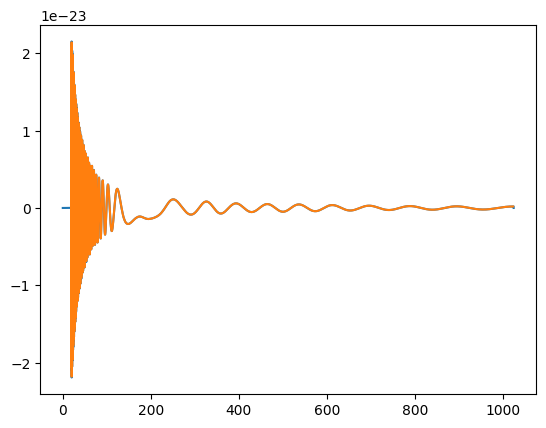

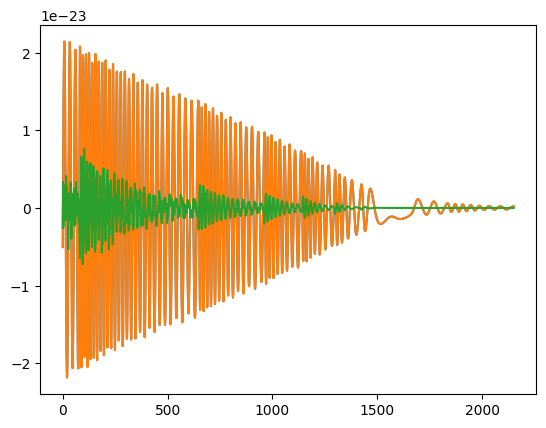

In [39]:
plt.plot(ufd(), pols_hetp["h_plus"])
plt.plot(mfd(), pols_het_dec_hetp["h_plus"])
plt.show()

plt.plot(pols_hetp_dec["h_plus"])
plt.plot(pols_het_dec_hetp["h_plus"])
plt.plot((pols_hetp_dec["h_plus"] - pols_het_dec_hetp["h_plus"])*100)
plt.show()

In [16]:
dict(parameters_het.iloc[0])

{'chirp_mass': 1.000171547511743,
 'mass_ratio': 0.7761697269279196,
 'phase': 5.75292436401179,
 'a_1': 0.6815291198620839,
 'a_2': 0.03199983595733824,
 'tilt_1': 1.1904449391652707,
 'tilt_2': 0.5754620283942509,
 'phi_12': 3.8570658115645595,
 'phi_jl': 3.677852836781032,
 'theta_jn': 0.4203860104715331,
 'lambda_1': 3758.538604596334,
 'luminosity_distance': 100.0,
 'geocent_time': 0.0}